In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import xarray as xr

import numpy as np
import metpy
import metpy.calc as mpcalc
from metpy.plots import ctables
from metpy.cbook import get_test_data
from metpy.units import units
import os
import scipy.integrate as integrate
import datetime as dt
import glob
import json
from datetime import datetime
from datetime import timedelta
from metpy.plots import ctables
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

#import wrf
import scipy
#import xcape
import xarray

In [9]:
file_dir = '/data/icond2/meteograms'
os.chdir(file_dir)

data_det = xr.open_dataset('icond2_sfc.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51,1))


file_dir = '/data/icond2eps_2/'
os.chdir(file_dir)

data = xarray.open_dataset('icond2eps_t2m_latlon.grib2', engine='cfgrib')
data.to_netcdf('icond2eps_t2m.nc')
data_t = xr.open_dataset('icond2eps_t2m.nc').sel(longitude=slice(3,9,1),latitude=slice(49,51.02,1))

print(data_det)
print(data_t)

Ignoring index file 'icond2eps_t2m_latlon.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:    (longitude: 301, latitude: 101, time: 48)
Coordinates:
  * longitude  (longitude) float32 3.0 3.02 3.04 3.06 ... 8.94 8.96 8.98 9.0
  * latitude   (latitude) float32 49.0 49.02 49.04 49.06 ... 50.96 50.98 51.0
  * time       (time) datetime64[ns] 2022-07-19T07:00:00 ... 2022-07-21T06:00:00
Data variables:
    sde        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    r2         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t          (time, latitude, longitude) float32 ...
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    gust       (time, latitude, longitude) float32 ...
    WW         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-18 07:42:45 GMT by grib_to_netcdf-2.22.1: grib_t

In [10]:
# To parse the full dataset, we can call parse_cf without an argument, and assign the returned Dataset.

data_t = data_t.metpy.parse_cf()
data_det = data_det.metpy.parse_cf()

x, y = data_t['t2m'].metpy.coordinates('x', 'y')

time = data_t['t2m'].step
member = data_t['t2m'].number
#time2 = data_det_rr['tp'].metpy.time

timeinit = data_t.time
timeinit = datetime.utcfromtimestamp(timeinit.item()/1e9)
print(timeinit)

#hsurf = data_hsurf['h']*3.28084 #convert to feet
#uh = data_uh['UH_MAX']
t = data_t['t2m']
#rr = data_rr['tp']
#det_rr = data_det_rr['tp']
det_t = data_det['t2m']
#det_uh = data_det_uhmax['UH_MAX']

#rr.data = np.nan_to_num(rr.data, copy=True, nan=0)
print(np.shape(t.data))

#vmax_median = np.percentile(vmax, 50)
t_median = np.empty((49,101,301))
t_95 = np.empty((49,101,301))

for i in range(0,49):
    for j in range (0,101):
        for k in range(0,301):
            t_median[i,j,k] = np.percentile(t.data[:,i,j,k],50)

print(np.shape(t_median))

for i in range(0,49):
    for j in range (0,101):
        for k in range(0,301):
            t_95[i,j,k] = np.percentile(t.data[:,i,j,k],95)

/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/metpy/xarray.py:349: UserWarning: More than one time coordinate present for variable "t2m".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Found valid latitude/longitude coordinates, assuming latitude_longitude for projection grid_mapping variable
Foun

2022-07-19 03:00:00
(20, 49, 101, 301)
(49, 101, 301)


In [4]:
#t_prob_38 = np.empty((49,101,301))
t_prob_35 = np.empty((49,101,301))
t_prob_33 = np.empty((49,101,301))
t_prob_30 = np.empty((49,101,301))

#q = 38
z = 35
v = 33
w = 30



# for i in range(0,49):
#     for j in range (0,101):
#         for k in range(0,301):
#             t_prob_38[i,j,k] = (sum(h > q for h in (t.data[:,i,j,k]-273.15))/20)*100
            
# for i in range(0,49):
#     for j in range (0,101):
#         for k in range(0,301):
#             t_prob_35[i,j,k] = (sum(h > z for h in (t.data[:,i,j,k]-273.15))/20)*100
            
# for i in range(0,49):
#     for j in range (0,101):
#         for k in range(0,301):
#             t_prob_33[i,j,k] = (sum(h > v for h in (t.data[:,i,j,k]-273.15))/20)*100
            
# for i in range(0,49):
#     for j in range (0,101):
#         for k in range(0,301):
#             t_prob_30[i,j,k] = (sum(h > w for h in (t.data[:,i,j,k]-273.15))/20)*100
            
for i in range(0,49):
    for j in range (0,101):
        for k in range(0,301):
            count = np.count_nonzero((t.data[:,i,j,k]-273.15) > 30)
            t_prob_30[i,j,k] = (count/20)*100
            count = 0
            
for i in range(0,49):
    for j in range (0,101):
        for k in range(0,301):
            count = np.count_nonzero((t.data[:,i,j,k]-273.15) > 33)
            t_prob_33[i,j,k] = (count/20)*100
            count = 0
            
for i in range(0,49):
    for j in range (0,101):
        for k in range(0,301):
            count = np.count_nonzero((t.data[:,i,j,k]-273.15) > 35)
            t_prob_35[i,j,k] = (count/20)*100
            count = 0
            
print(t_prob_30)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


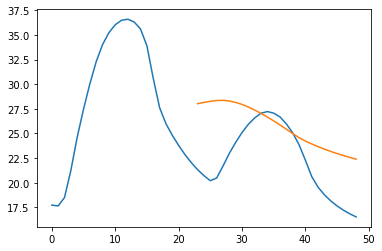

In [12]:
import pandas as pd
t_med_mean = np.mean(t_median, axis=(1, 2))-273.15
#print(t_med_mean)
d = pd.Series(t_med_mean)
t_med_average = d.rolling(24).mean()

plt.plot(t_med_mean)
plt.plot(t_med_average)

In [5]:
def plot_background(ax):
    ax.set_extent([5, 7, 49.1, 50.5])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), LineWidth=2)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'),LineWidth=2)
    #gl = ax.gridlines(draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False
    #gl.ylabels_right = False
    #gl.xlabel_style = {'size': 12, 'color': 'black'}
    #gl.ylabel_style = {'size': 12, 'color': 'black'}
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    return ax

#import matplotlib
#cmap = matplotlib.cm.get_cmap('cubehelix_r')
#for i in range(20):
    #rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    #print(rgba)
    
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')
newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

cmap2 = ctables.colortables.get_colortable('NWSReflectivity')
newcmap2 = ListedColormap(cmap2(np.linspace(0.2, 0.96, 28)))

cmap4 = ctables.colortables.get_colortable('precipitation')
newcmap4 = ListedColormap(cmap4(np.linspace(0, 0.75, 15)))


bounds = [0,0.1,0.5,1,3,5,10,15,20,25,30,35,40,45,50,55]
norm = BoundaryNorm(bounds, newcmap4.N)
bounds6 = [0,0.1,5,10,15,20,25,30,40,50,60,70,80,90,100,110]
norm6 = BoundaryNorm(bounds6, newcmap4.N)
bounds24 = [0,0.1,5,10,20,30,40,50,60,70,80,90,100,110,120,130]
norm24 = BoundaryNorm(bounds6, newcmap4.N)


#cmap2 = ListedColormap(colors2)
#newcmap2 = ListedColormap(cmap2(np.linspace(0, 0.9, 29)))

In [6]:
# Create the figure and plot background on different axes
crs = ccrs.Mercator()

for i in range(1,49):
    
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(25, 10), constrained_layout=False,
                  subplot_kw={'projection': crs})
    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
        
    timestep=timeinit+timedelta(hours=i)
    time2 = data_det['t2m'].metpy.time
    #time3 = data_hsurf['h'].metpy.time
    clevs_t= np.arange(-10,42,1)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
        
    # Upper left plot
    cf1 = axlist[0].contourf(data_t.longitude, data_t.latitude, (t_median[i,:,:]-273.15), 
                      clevs_t, cmap='Spectral_r', transform=ccrs.PlateCarree())
    ccf1= axlist[0].contour(data_t.longitude, data_t.latitude, (t_median[i,:,:]-273.15), 
                         [-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40], 
                            colors='black', linestyles="dotted",transform=ccrs.PlateCarree())
    axlist[0].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[0].set_title('50th Percentile (Median)', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[0], orientation='vertical', 
                     # ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                            #  shrink=0.73, fraction=0.1, pad=0)
    #cb1.set_label('km/h', size='x-large')
    
    cf2 = axlist[1].contourf(data_t.longitude, data_t.latitude, (t_95[i,:,:]-273.15), 
                     clevs_t, cmap='Spectral_r', transform=ccrs.PlateCarree())
    ccf2= axlist[1].contour(data_t.longitude, data_t.latitude, (t_95[i,:,:]-273.15), 
                         [-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40], 
                            colors='black', linestyles="dotted",transform=ccrs.PlateCarree())
    axlist[1].clabel(ccf2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[1].set_title('95th Percentile', fontsize=16)
    #cb2= fig.colorbar(cf2, ax=axlist[1], orientation='vertical', 
                      #ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                             # shrink=0.73, fraction=0.1, pad=0)
   # cb2.set_label('km/h', size='x-large')

    cf3 = axlist[2].contourf(data_det.longitude, data_det.latitude, (det_t.metpy.loc[{'time': time2[i-1]}]-273.15), 
                          clevs_t,cmap='Spectral_r',transform=ccrs.PlateCarree())
    ccf3= axlist[2].contour(data_det.longitude, data_det.latitude, (det_t.metpy.loc[{'time': time2[i-1]}]-273.15), 
                         [-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40], 
                            colors='black', linestyles="dotted",transform=ccrs.PlateCarree())
    axlist[2].clabel(ccf3, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[2].set_title('Deterministic', fontsize=16)
   # cb3= fig.colorbar(cf3, ax=axlist[2], orientation='vertical', 
                      #ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                              #shrink=0.73, fraction=0.1, pad=0)
    #cb3.set_label('km/h', size='x-large')
    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                       fraction=0.01, aspect=30, pad=0.02)
    cb.set_label('°C', size='x-large')


    # Set figure title
    plt.gcf().text(0.130, 0.90, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.130, 0.86, 'Parameter: Temperature 2 m AGL', fontsize=20)
    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_t2m_perc_'
    suffix='.jpeg'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=85)
    plt.close(fig)

icond2eps_t2m_perc_1.jpeg


/home/lmathias/anaconda3/envs/metpy/lib/python3.9/site-packages/cartopy/mpl/feature_artist.py:211: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  c = matplotlib.collections.PathCollection(paths,


icond2eps_t2m_perc_2.jpeg
icond2eps_t2m_perc_3.jpeg
icond2eps_t2m_perc_4.jpeg
icond2eps_t2m_perc_5.jpeg
icond2eps_t2m_perc_6.jpeg
icond2eps_t2m_perc_7.jpeg
icond2eps_t2m_perc_8.jpeg
icond2eps_t2m_perc_9.jpeg
icond2eps_t2m_perc_10.jpeg
icond2eps_t2m_perc_11.jpeg
icond2eps_t2m_perc_12.jpeg
icond2eps_t2m_perc_13.jpeg
icond2eps_t2m_perc_14.jpeg
icond2eps_t2m_perc_15.jpeg
icond2eps_t2m_perc_16.jpeg
icond2eps_t2m_perc_17.jpeg
icond2eps_t2m_perc_18.jpeg
icond2eps_t2m_perc_19.jpeg
icond2eps_t2m_perc_20.jpeg
icond2eps_t2m_perc_21.jpeg
icond2eps_t2m_perc_22.jpeg
icond2eps_t2m_perc_23.jpeg
icond2eps_t2m_perc_24.jpeg
icond2eps_t2m_perc_25.jpeg
icond2eps_t2m_perc_26.jpeg
icond2eps_t2m_perc_27.jpeg
icond2eps_t2m_perc_28.jpeg
icond2eps_t2m_perc_29.jpeg
icond2eps_t2m_perc_30.jpeg
icond2eps_t2m_perc_31.jpeg
icond2eps_t2m_perc_32.jpeg
icond2eps_t2m_perc_33.jpeg
icond2eps_t2m_perc_34.jpeg
icond2eps_t2m_perc_35.jpeg
icond2eps_t2m_perc_36.jpeg
icond2eps_t2m_perc_37.jpeg
icond2eps_t2m_perc_38.jpeg
icond2eps

In [7]:
# Create the figure and plot background on different axes
crs = ccrs.Mercator()
#t_prob_38_smooth = scipy.ndimage.zoom(t_prob_38, 1.2)
t_prob_35_smooth = scipy.ndimage.zoom(t_prob_35, 1.2)
t_prob_33_smooth = scipy.ndimage.zoom(t_prob_33, 1.2)
t_prob_30_smooth = scipy.ndimage.zoom(t_prob_30, 1.2)
x_smooth = scipy.ndimage.zoom(x, 1.2)
y_smooth = scipy.ndimage.zoom(y, 1.2)
#t_prob_38_smooth = np.where(t_prob_38_smooth < 100, t_prob_38_smooth, 100)
t_prob_35_smooth = np.where(t_prob_35_smooth < 100, t_prob_35_smooth, 100)
t_prob_33_smooth = np.where(t_prob_33_smooth < 100, t_prob_33_smooth, 100)
t_prob_30_smooth = np.where(t_prob_30_smooth < 100, t_prob_30_smooth, 100)
#t_prob_38_smooth = np.where(t_prob_38_smooth > 0, t_prob_38_smooth, 0)
t_prob_35_smooth = np.where(t_prob_35_smooth > 0, t_prob_35_smooth, 0)
t_prob_33_smooth = np.where(t_prob_33_smooth > 0, t_prob_33_smooth, 0)
t_prob_30_smooth = np.where(t_prob_30_smooth > 0, t_prob_30_smooth, 0)


#print(np.max(ceil_prob_15_smooth))

for i in range(1,49):
    
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(25, 10), constrained_layout=False,
                  subplot_kw={'projection': crs})
    # Set height padding for plots
    fig.set_constrained_layout_pads(w_pad=0., h_pad=10, hspace=0., wspace=0.)
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
        
    timestep=timeinit+timedelta(hours=i)
    time2 = data_det['t2m'].metpy.time
    #time3 = data_hsurf['h'].metpy.time
    clevs_prob= np.arange(0,110,10)
    # cmap = plt.get_cmap('gist_ncar')
    # newcmap = ListedColormap(cmap(np.linspace(0.15, 0.9, 30)))
        
    # Upper left plot
    cf1 = axlist[0].contourf(x, y, t_prob_30[i,:,:],
                      clevs_prob, cmap='RdPu', transform=ccrs.PlateCarree())
    #ccf1= axlist[0].contour(data_ceil.longitude, data_ceil.latitude,  ceil_median[i,:,:],
                     #[100,200,500,1000,1500], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
    #axlist[0].clabel(ccf1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[0].set_title('Probability T > 30 °C', fontsize=16)
    #cb1= fig.colorbar(cf1, ax=axlist[0], orientation='vertical', 
                     # ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                            #  shrink=0.73, fraction=0.1, pad=0)
    #cb1.set_label('km/h', size='x-large')
    
    cf2 = axlist[1].contourf(x, y, t_prob_33[i,:,:],
                      clevs_prob, cmap='RdPu', transform=ccrs.PlateCarree())
    #ccf2= axlist[1].contour(data_ceil.longitude, data_ceil.latitude,  ceil_95[i,:,:],
                     #[100,200,500,1000,1500], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
    #axlist[1].clabel(ccf2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[1].set_title('Probability T > 33 °C', fontsize=16)
    #cb2= fig.colorbar(cf2, ax=axlist[1], orientation='vertical', 
                      #ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                             # shrink=0.73, fraction=0.1, pad=0)
   # cb2.set_label('km/h', size='x-large')

    cf3 = axlist[2].contourf(x, y, t_prob_35[i,:,:], 
                      clevs_prob, cmap='RdPu', transform=ccrs.PlateCarree())
    #ccf3= axlist[2].contour(data_det_vmax.longitude, data_det_vmax.latitude, det_gust.metpy.loc[{'time': time2[i-1]}]*3.6,
                     #[30,50,70,90,110,130], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
    #axlist[2].clabel(ccf3, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
    axlist[2].set_title('Probability T > 35 °C', fontsize=16)
   # cb3= fig.colorbar(cf3, ax=axlist[2], orientation='vertical', 
                      #ticks=(10,20,30,40,50,60,70,80,90,100,110,120,130),
                              #shrink=0.73, fraction=0.1, pad=0)
    #cb3.set_label('km/h', size='x-large')
    
#     cf4 = axlist[3].contourf(x_smooth, y_smooth, t_prob_38_smooth[i,:,:], 
#                       clevs_prob, cmap='BuPu',transform=ccrs.PlateCarree())
#     #ccf3= axlist[2].contour(data_det_vmax.longitude, data_det_vmax.latitude, det_gust.metpy.loc[{'time': time2[i-1]}]*3.6,
#                      #[30,50,70,90,110,130], colors='dimgrey', linestyles="dotted",transform=ccrs.PlateCarree())
#     #axlist[2].clabel(ccf3, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
#     axlist[3].set_title('Probability T > 38 °C', fontsize=16)

    cb = fig.colorbar(cf1, ax=axarr.ravel().tolist(), orientation='vertical',
                      ticks=(0,10,20,30,40,50,60,70,80,90,100), fraction=0.01, aspect=30, pad=0.02)
    cb.set_label('%', size='x-large')

    # Set figure title
    plt.gcf().text(0.130, 0.90, 'Model: ICON-D2-EPS 0.02° | ' + timeinit.strftime('Init: %d.%m.%Y %H:%M UTC | ')+timestep.strftime('Valid: %d.%m.%Y %H:%M UTC'), fontsize=20)
    plt.gcf().text(0.130, 0.86, 'Parameter: Temperature 2 m AGL', fontsize=20)
    # Display the plot
    time2 = str(i*1)
    base_filename='icond2eps_t2m_prob_'
    suffix='.jpeg'
    my_file = base_filename+time2+suffix
    print(my_file)
    plt.savefig(my_file, format="jpeg", bbox_inches='tight', dpi=85)
    plt.close(fig)

icond2eps_t2m_prob_1.jpeg
icond2eps_t2m_prob_2.jpeg
icond2eps_t2m_prob_3.jpeg
icond2eps_t2m_prob_4.jpeg
icond2eps_t2m_prob_5.jpeg
icond2eps_t2m_prob_6.jpeg
icond2eps_t2m_prob_7.jpeg
icond2eps_t2m_prob_8.jpeg


TopologyException: side location conflict at 6.3999999999999568 50.420000000001131


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fa6cc933580>

TopologyException: side location conflict at 6.3999999999999568 50.420000000001131


TopologicalError: The operation 'GEOSContains_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x7fa6cc761850>

<Figure size 1800x720 with 3 Axes>